Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
import time
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')


In [3]:
arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [4]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


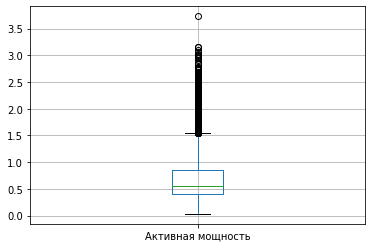

In [5]:
arc.boxplot('Активная мощность')

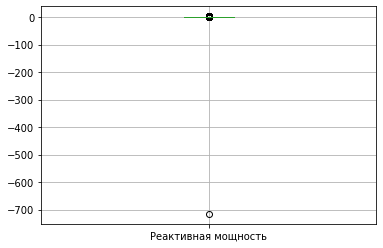

In [6]:
arc.boxplot('Реактивная мощность')

In [7]:
arc.describe().T.style.bar(
    subset=['mean'],color='#205fA2').background_gradient(subset=['std'], cmap='RdYlBu').background_gradient(
    subset=['min'], cmap='terrain_r').background_gradient(subset=['max'], cmap='terrain').background_gradient(
    subset=['50%'], cmap='CMRmap')

,count,mean,std,min,25%,50%,75%,max
key,14876,1615.22,934.572,1,806,1617,2429,3241
Активная мощность,14876,0.670441,0.408159,0.0300019,0.395297,0.555517,0.857034,3.7316
Реактивная мощность,14876,0.452592,5.8787,-715.505,0.290991,0.415962,0.637371,2.67639


In [8]:
bulk.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [9]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
bulk.describe().T.style.bar(
    subset=['mean'],color='#205fA2').background_gradient(subset=['std'], cmap='RdYlBu').background_gradient(
    subset=['min'], cmap='terrain_r').background_gradient(subset=['max'], cmap='terrain').background_gradient(
    subset=['50%'], cmap='CMRmap')

,count,mean,std,min,25%,50%,75%,max
key,3129,1624.38,933.338,1,816,1622,2431,3241
Bulk 1,252,39.2421,18.2777,10,27,31,46,185
Bulk 2,22,253.045,21.1806,228,242,251.5,257.75,325
Bulk 3,1298,113.879,75.4835,6,58,97.5,152,454
Bulk 4,1014,104.394,48.1841,12,72,102,133,281
Bulk 5,77,107.026,81.7906,11,70,86,132,603
Bulk 6,576,118.925,72.0578,17,69.75,100,157,503
Bulk 7,25,305.6,191.023,47,155,298,406,772
Bulk 8,1,49,nan,49,49,49,49,49
Bulk 9,19,76.3158,21.7206,63,66,68,70.5,147


In [11]:
bulk_time.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [12]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [13]:
gas.head(15)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [14]:
gas.describe().T.style.bar(
    subset=['mean'],color='#205fA2').background_gradient(subset=['std'], cmap='RdYlBu').background_gradient(
    subset=['min'], cmap='terrain_r').background_gradient(subset=['max'], cmap='terrain').background_gradient(
    subset=['50%'], cmap='CMRmap')

,count,mean,std,min,25%,50%,75%,max
key,3239,1621.86,935.386,1,812.5,1622,2431.5,3241
Газ 1,3239,11.0021,6.22033,0.00839853,7.04309,9.83627,13.7699,77.995


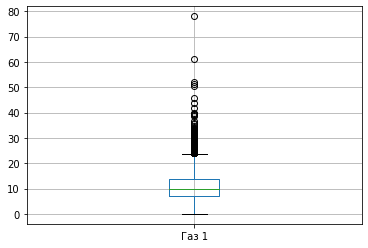

In [15]:
gas.boxplot('Газ 1')

In [16]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
temp.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [18]:
temp.describe().T.style.bar(
    subset=['mean'],color='#205fA2').background_gradient(subset=['std'], cmap='RdYlBu').background_gradient(
    subset=['min'], cmap='terrain_r').background_gradient(subset=['max'], cmap='terrain').background_gradient(
    subset=['50%'], cmap='CMRmap')

,count,mean,std,min,25%,50%,75%,max
key,15907,1607.88,942.212,1,790,1618,2427,3241
Температура,13006,1591.84,21.3759,1191,1581,1591,1601,1705


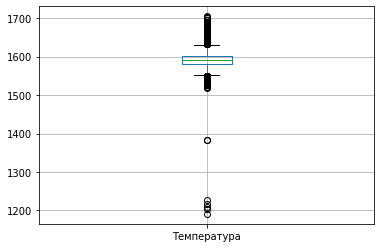

In [19]:
temp.boxplot('Температура')

In [20]:
temp[temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [21]:
temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

In [22]:
wire.head(15)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [24]:
wire_time.head(15)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Был проведен иследовательский анализ данных, видим что имеются пропуски, так же имеются выбросы, отличные от остальных, так же было замечено, что реактивная мощность есть отрицательное, и если верить википедии, то это является нормально

# План работ  
начнем с обработки данных, заполним пропуски нулями, именна столбцов к нужным типам, объединяем таблицы по ключю, после объеднринеия удаляем строки где нет данных по температуре. приводим к нуженым типам, и проверим на мультиколлинеарность, после обработки данных, разделяем на features и terget, обучающую и тестовую, и приступим к обучению моделей. после проверки на тестовой выборке провести анализ важности факторов.


Обработка данных

In [26]:
arc.columns=['key', 'start_heat', 'end_heat', 'active_power', 'reactive_power'] #переименуем столбцы
arc = arc.query('reactive_power > 0') # удалим выбросы по реактивной мощности
arc_sum = arc.pivot_table(index=['key'], values=['active_power', 'reactive_power'], aggfunc='sum') # групируем данные по ключу и суммируя мощность
arc_sum.columns=['sum_active_power', 'sum_reactive_power']
arc_sum.head(15)

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
6,3.955108,2.689175
7,2.547375,1.561295
8,3.762755,2.680698
9,2.081951,1.478671


In [27]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [28]:
temp.columns = ['key', 'time_meas', 'temp']

In [29]:
temp_bad_key = (temp['key'].value_counts() < 2).sum() # найдем ключи где меньше одной итерации и удалим их
temp_good_keys = list(temp['key'].value_counts().index[:-temp_bad_key])
temp = temp.query('key in @temp_good_keys')
temp['key'].value_counts()

44      16
46      16
1513    16
1214    16
2108    15
        ..
151      2
2423     2
273      2
3033     2
800      2
Name: key, Length: 3214, dtype: int64

In [30]:
temp_time = temp.pivot_table(index=['key'], aggfunc={'time_meas': [np.max, np.min]}) # найдем даты начала и конца итерации
temp_time.columns=['max', 'time_meas']
temp_time

,max,time_meas
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
3237,2019-08-31 23:05:43,2019-08-31 22:44:04
3238,2019-08-31 23:43:00,2019-08-31 23:30:31
3239,2019-09-01 02:24:15,2019-09-01 01:31:47


In [31]:
temp_final = temp_time.merge(temp, on='time_meas', how='left') # найдем температуру на начало и конец итерации применяя найденные даты
temp_final = temp_final.drop(['time_meas', 'key'], axis=1)
temp_final.columns=['time_meas', 'temp_start']
temp_final = temp_final.merge(temp, on='time_meas', how='left')
del temp_final['time_meas']
temp_final = temp_final.set_index('key')
temp_final.columns = ['temp_start', 'temp_end']
temp_final.dropna(subset=['temp_end'], inplace=True)
temp_final

,temp_start,temp_end
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


In [32]:
temp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
temp_start    2475 non-null float64
temp_end      2475 non-null float64
dtypes: float64(2)
memory usage: 58.0 KB


In [33]:
bulk = bulk.set_index('key') # переименуем столбцы в таблицах
bulk.columns = [f'bulk_{x}' for x in range(1,16)]
gas = gas.set_index('key')
gas.columns = ['gas']
wire = wire.set_index('key')
wire.columns = [f'wire_{x}' for x in range(1,10)]

In [34]:
data = pd.concat([arc_sum, temp_final, bulk, gas, wire], axis=1, sort=False) # объединяем это все в одну таблицу
data = data.dropna(subset=['temp_end']) # Удаляем итерации где нет замера температуры на конец итерации
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 29 columns):
sum_active_power      2475 non-null float64
sum_reactive_power    2475 non-null float64
temp_start            2475 non-null float64
temp_end              2475 non-null float64
bulk_1                199 non-null float64
bulk_2                13 non-null float64
bulk_3                965 non-null float64
bulk_4                814 non-null float64
bulk_5                53 non-null float64
bulk_6                443 non-null float64
bulk_7                14 non-null float64
bulk_8                1 non-null float64
bulk_9                13 non-null float64
bulk_10               143 non-null float64
bulk_11               130 non-null float64
bulk_12               1882 non-null float64
bulk_13               14 non-null float64
bulk_14               2137 non-null float64
bulk_15               1713 non-null float64
gas                   2473 non-null float64
wire_1                2348 non-n

In [35]:
del data['wire_5'] # удаляем столбец потому что он пустой
data = data.fillna(0) # заполняем пропуски нулями

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 28 columns):
sum_active_power      2475 non-null float64
sum_reactive_power    2475 non-null float64
temp_start            2475 non-null float64
temp_end              2475 non-null float64
bulk_1                2475 non-null float64
bulk_2                2475 non-null float64
bulk_3                2475 non-null float64
bulk_4                2475 non-null float64
bulk_5                2475 non-null float64
bulk_6                2475 non-null float64
bulk_7                2475 non-null float64
bulk_8                2475 non-null float64
bulk_9                2475 non-null float64
bulk_10               2475 non-null float64
bulk_11               2475 non-null float64
bulk_12               2475 non-null float64
bulk_13               2475 non-null float64
bulk_14               2475 non-null float64
bulk_15               2475 non-null float64
gas                   2475 non-null float64
wire_1       

In [37]:
data.describe().T.style.bar(subset=['mean'],color='#205fA2').background_gradient(subset=['std'], cmap='RdYlBu').background_gradient(subset=['min'], cmap='terrain_r').background_gradient(subset=['max'], cmap='terrain').background_gradient(subset=['50%'], cmap='CMRmap')

,count,mean,std,min,25%,50%,75%,max
sum_active_power,2475,3.12743,1.42605,0.186226,2.1483,3.01637,3.90805,17.4965
sum_reactive_power,2475,2.33069,1.07867,0.158247,1.60733,2.22948,2.9056,12.588
temp_start,2475,1588.4,29.243,1191,1572,1588,1605,1679
temp_end,2475,1595.34,16.0232,1541,1587,1593,1599,1700
bulk_1,2475,3.22545,12.0674,0,0,0,0,185
bulk_2,2475,1.33859,18.5135,0,0,0,0,325
bulk_3,2475,44.7919,73.9711,0,0,0,73,454
bulk_4,2475,35.2226,57.656,0,0,0,72,281
bulk_5,2475,2.48444,21.7401,0,0,0,0,603
bulk_6,2475,21.3374,54.5721,0,0,0,0,503


Text(0.5, 1, 'Imbalaced Correlation')

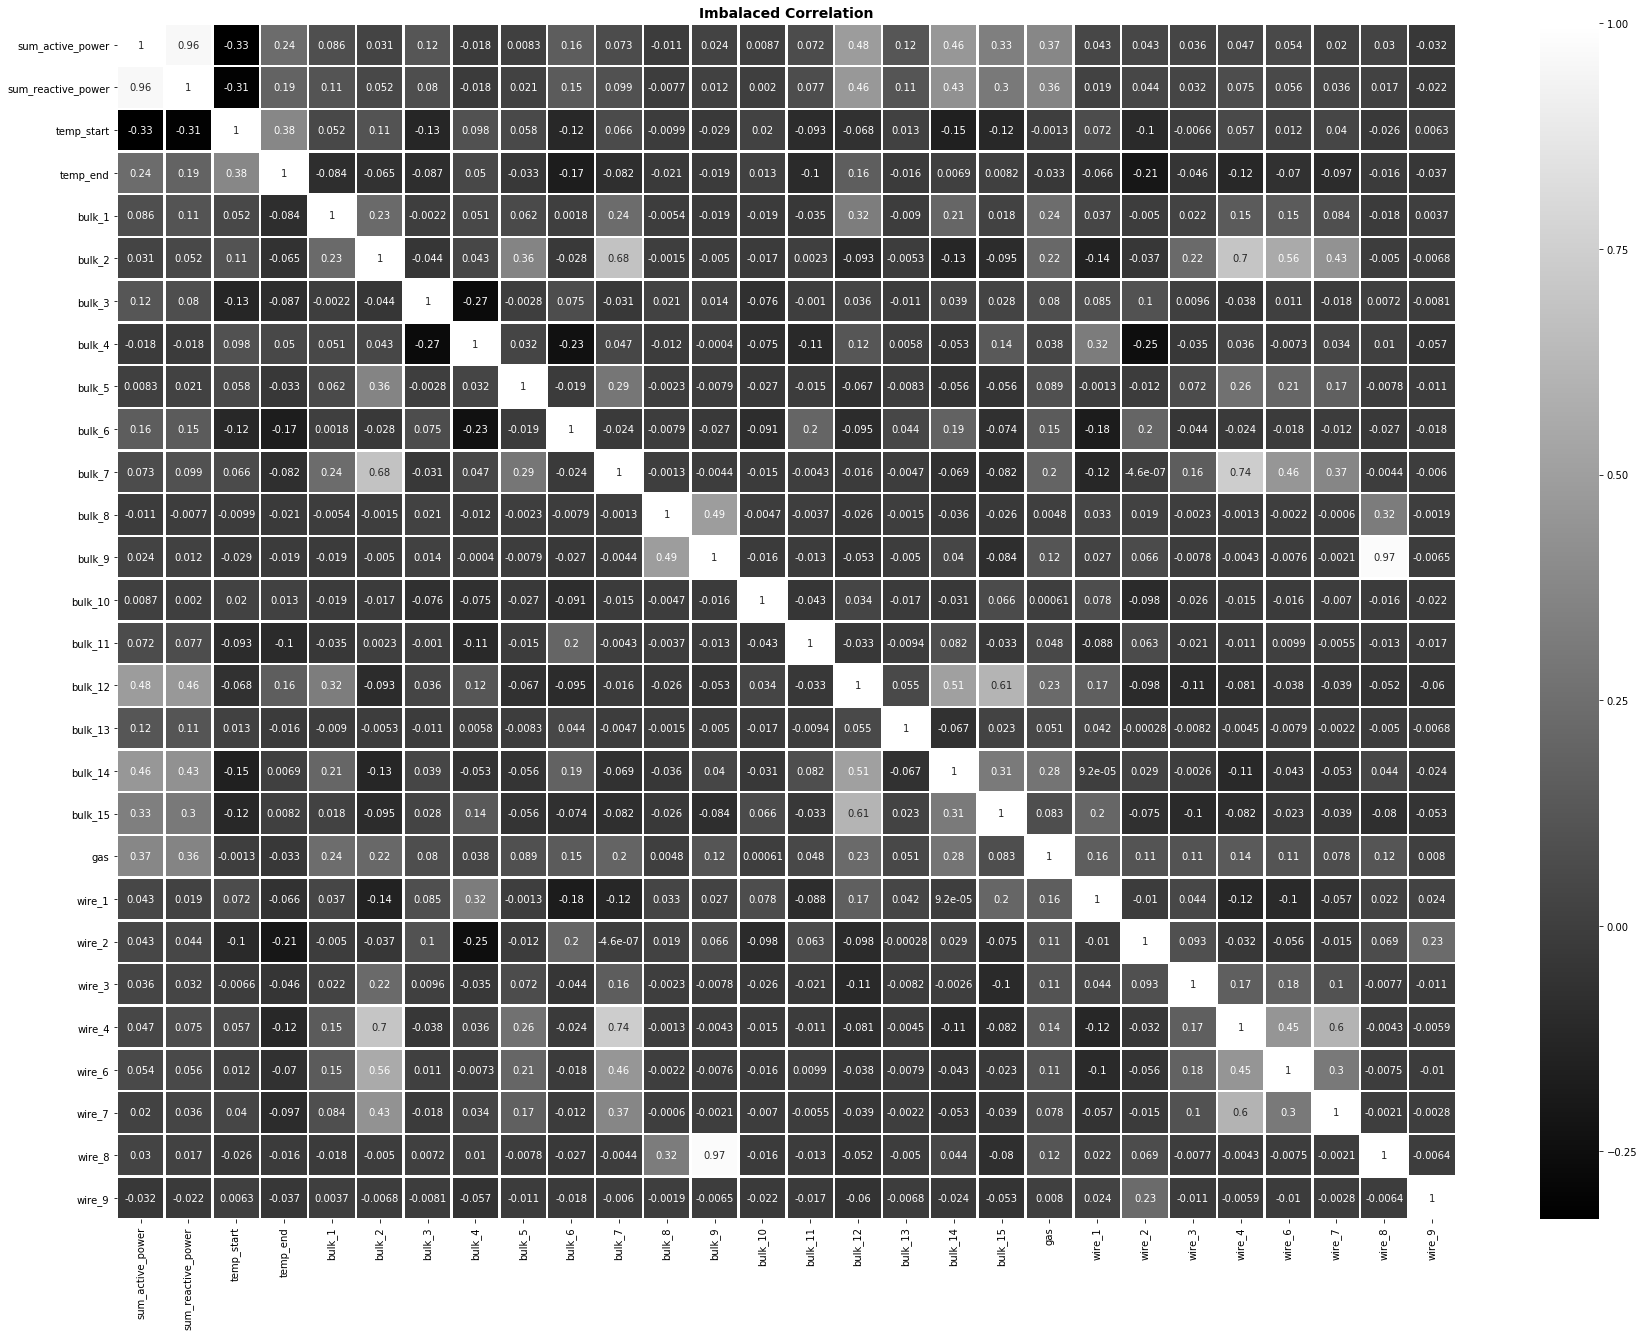

In [38]:
f, (ax1) = plt.subplots(1 ,figsize=(30,22))

sb.heatmap(data.corr(), ax=ax1, cmap='gray',annot=True, linewidths=1.5)
ax1.set_title("Imbalaced Correlation",fontsize=14, fontweight='bold')

In [39]:
data = data.drop(['sum_reactive_power', 'wire_8', 'wire_4'], axis=1) # удаляем столбцы с сильной корреляцией

разделяем данные

In [40]:

features = data.drop('temp_end', axis=1)
target = data['temp_end']



In [41]:
random_state = 4102020
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.2,
                                                            random_state=random_state)
cv_counts = 5

подбираем гиперпараметры под разные модели

# LinearRegression

In [42]:
%%time

lr = LinearRegression()

cv_mae_lr = (cross_val_score(lr, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_mae_lr)

Mean MAE from CV of LinearRegression = 8.099772584249624
Wall time: 62.9 ms


# RandomForestRegressor

In [43]:
%%time

rfr = RandomForestRegressor() 
param = {'n_estimators':[x for x in range(10, 100, 20)],
          'criterion':['mae'],
          'max_depth':[x for x in range(1, 10, 1)],
          'random_state':[random_state]}

grid_rfr = GridSearchCV(rfr, param, scoring='neg_mean_absolute_error', cv=cv_counts)
grid_rfr.fit(features_train, target_train)

best_params_rfr = grid_rfr.best_params_
print('best parameters', best_params_rfr)


best parameters {'criterion': 'mae', 'max_depth': 9, 'n_estimators': 90, 'random_state': 4102020}
Wall time: 25min 54s


# CatBoostRegressor

In [44]:
%%time
cat = CatBoostRegressor()
param = {'iterations':[x for x in range(1, 501, 100)],
          'learning_rate': [0.01, 0.03, 0.1, 0.3],
          'depth':[x for x in range(1, 5, 1)],
          'random_state':[random_state]}
cv = KFold(n_splits=3, shuffle=True)

grid_cat = GridSearchCV(cat, param, cv=cv)
grid_cat.fit(features_train, target_train)

best_params_cat = grid_cat.best_params_
print('best parameters', best_params_cat)


0:	learn: 16.0086183	total: 140ms	remaining: 0us
0:	learn: 15.9108940	total: 679us	remaining: 0us
0:	learn: 16.0351472	total: 682us	remaining: 0us
0:	learn: 15.9262983	total: 820us	remaining: 0us
0:	learn: 15.8340717	total: 673us	remaining: 0us
0:	learn: 15.9719048	total: 627us	remaining: 0us
0:	learn: 15.6476933	total: 639us	remaining: 0us
0:	learn: 15.5743693	total: 775us	remaining: 0us
0:	learn: 15.7585322	total: 685us	remaining: 0us
0:	learn: 14.9393237	total: 690us	remaining: 0us
0:	learn: 14.9164834	total: 684us	remaining: 0us
0:	learn: 15.2210842	total: 672us	remaining: 0us
0:	learn: 16.0086183	total: 646us	remaining: 64.6ms
1:	learn: 15.9699688	total: 1.33ms	remaining: 66ms
2:	learn: 15.9297001	total: 1.97ms	remaining: 64.5ms
3:	learn: 15.8901000	total: 2.83ms	remaining: 68.7ms
4:	learn: 15.8533596	total: 3.62ms	remaining: 69.5ms
5:	learn: 15.8172381	total: 4.53ms	remaining: 71.8ms
6:	learn: 15.7795227	total: 5.38ms	remaining: 72.2ms
7:	learn: 15.7424387	total: 6.18ms	remaining

# LGBMRegressor

In [45]:
%%time
lgbm = LGBMRegressor()
param = {'learning_rate': [0.01, 0.03, 0.1, 0.3],
          'n_estimators':[x for x in range(100, 1000, 100)],
          'max_depth':[x for x in range(1, 10, 1)],
          'random_state':[random_state]}
grid_lgbm = GridSearchCV(lgbm, param, cv=cv)
grid_lgbm.fit(features_train, target_train)

best_params_lgbm = grid_lgbm.best_params_
print('best parameters', best_params_lgbm)

best parameters {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 400, 'random_state': 4102020}
Wall time: 4min 25s


# DecisionTreeRegressor

In [46]:
%%time

dtr = DecisionTreeRegressor() 
param = {'criterion':['mae'],
          'max_depth':[x for x in range(1, 10, 1)],
          'random_state':[random_state]}

grid_dtr = GridSearchCV(dtr, param, scoring='neg_mean_absolute_error')
grid_dtr.fit(features_train, target_train)

best_params_dtr = grid_dtr.best_params_
print('best parameters', best_params_dtr)

best parameters {'criterion': 'mae', 'max_depth': 7, 'random_state': 4102020}
Wall time: 15.1 s


# LassoCV

In [47]:
%%time

lasso = LassoCV() 
param = {'n_alphas':[x for x in range(100, 300, 100)],
         'max_iter':[x for x in range(1, 200, 10)],
         'random_state':[random_state]}
cv = KFold(n_splits=3, shuffle=True)

grid_lasso = GridSearchCV(lasso, param, scoring='neg_mean_absolute_error', cv=cv)
grid_lasso.fit(features_train, target_train)

best_params_lasso = grid_lasso.best_params_
print('best parameters', best_params_lasso)


best parameters {'max_iter': 11, 'n_alphas': 200, 'random_state': 4102020}
Wall time: 15.1 s


# проверка моделей на тесте и выявление важности признаков

In [48]:
# напишем функции для просмотра важности признаков у моделей
def plot_bar(model): 
    test = model.feature_importances_
    tost = pd.Series(test, index=features_train.columns)
    tost.plot.bar()

In [49]:
# Напишем функцию для просмотра предсказания модели
def pred_tar(model, name):
    pred = model.predict(features_test)
    tar_test = target_test
    pred = pd.DataFrame(data=pred, columns=['predict'])
    tar_test = pd.DataFrame(data=target_test)
    sns.kdeplot(pred['predict'], shade=True)
    sns.kdeplot(tar_test['temp_end'], shade=True)
    plt.legend(['predict', 'target_test'])
    plt.title(name)

## Проверка на тесте LinearRegression

In [50]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_lr = mean_absolute_error(target_predict, target_test)
print('MAE на тесте LinearRegression =', test_mae_lr)

MAE на тесте LinearRegression = 9.99058093167823
Wall time: 0 ns


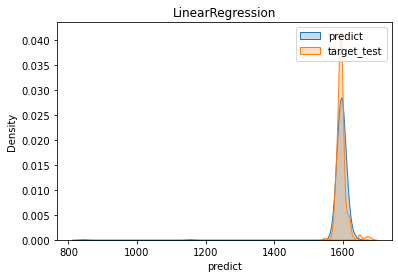

In [51]:
pred_tar(model, 'LinearRegression')

## Проверка на тесте RandomForestRegressor

In [52]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_rfr)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_rfr = mean_absolute_error(target_predict, target_test)
print('MAE на тесте RandomForestRegressor =', test_mae_rfr)

MAE на тесте RandomForestRegressor = 6.284567901234572
Wall time: 25.4 s


Text(0.5, 1.0, 'Важность признаков RandomForestRegressor')

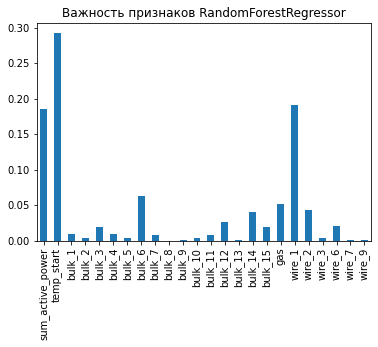

In [53]:
plot_bar(model)
plt.title('Важность признаков RandomForestRegressor')

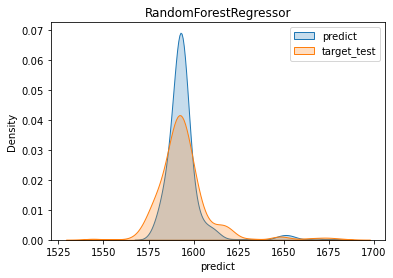

In [54]:
pred_tar(model, 'RandomForestRegressor')

## Проверка на тесте CatBoostRegressor

In [55]:
%%time

model = CatBoostRegressor()
model.set_params(**best_params_cat)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_cat = mean_absolute_error(target_predict, target_test)
print('MAE на тесте CatBoostRegressor =', test_mae_cat)

0:	learn: 15.3014382	total: 2.21ms	remaining: 885ms
1:	learn: 14.6422910	total: 4.43ms	remaining: 883ms
2:	learn: 14.0055376	total: 6.05ms	remaining: 803ms
3:	learn: 13.5305425	total: 7.73ms	remaining: 767ms
4:	learn: 13.0741991	total: 9.43ms	remaining: 747ms
5:	learn: 12.5951024	total: 11.1ms	remaining: 727ms
6:	learn: 12.1999490	total: 12.6ms	remaining: 712ms
7:	learn: 11.8993008	total: 14.4ms	remaining: 705ms
8:	learn: 11.5544936	total: 16.1ms	remaining: 700ms
9:	learn: 11.2661698	total: 17.7ms	remaining: 692ms
10:	learn: 11.0302709	total: 19.4ms	remaining: 687ms
11:	learn: 10.8018773	total: 21.1ms	remaining: 684ms
12:	learn: 10.6275399	total: 22.8ms	remaining: 679ms
13:	learn: 10.4665623	total: 24.4ms	remaining: 675ms
14:	learn: 10.3065597	total: 26.1ms	remaining: 672ms
15:	learn: 10.1603871	total: 27.8ms	remaining: 669ms
16:	learn: 10.0307681	total: 29.5ms	remaining: 665ms
17:	learn: 9.9663352	total: 31.1ms	remaining: 662ms
18:	learn: 9.8704205	total: 32.8ms	remaining: 660ms
19:	l

Text(0.5, 1.0, 'Важность признаков CatBoostRegressor')

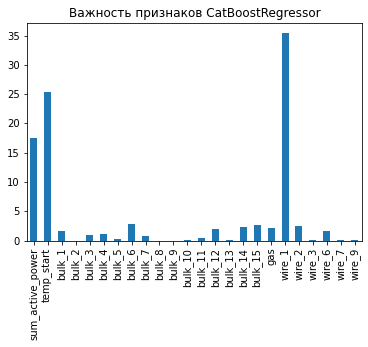

In [56]:
plot_bar(model)
plt.title('Важность признаков CatBoostRegressor')

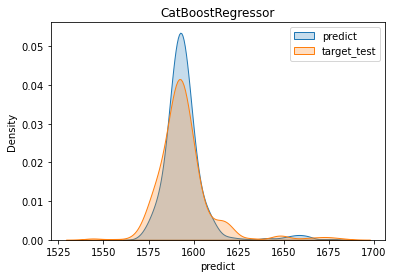

In [57]:
pred_tar(model, 'CatBoostRegressor')

## Проверка на тесте LGBMRegressor

In [58]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_lgbm)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_lgbm = mean_absolute_error(target_predict, target_test)
print('MAE на тесте LGBMRegressor =', test_mae_lgbm)

MAE на тесте LGBMRegressor = 6.1056176941359235
Wall time: 109 ms


Text(0.5, 1.0, 'Важность признаков LGBMRegressor')

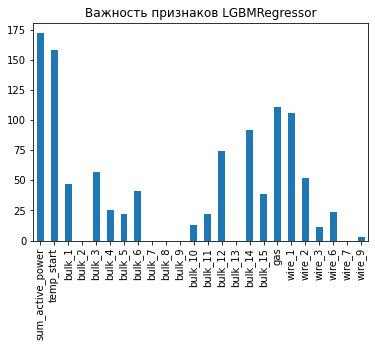

In [59]:
plot_bar(model)
plt.title('Важность признаков LGBMRegressor')

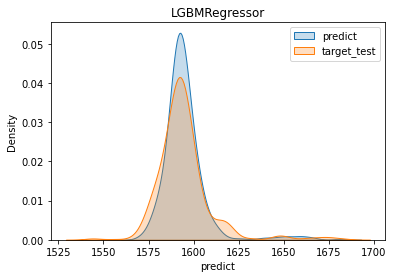

In [60]:
pred_tar(model, 'LGBMRegressor')

## Проверка на тесте DecisionTreeRegressor

In [61]:
%%time

model = DecisionTreeRegressor()
model.set_params(**best_params_dtr)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_dtr = mean_absolute_error(target_predict, target_test)
print('MAE на тесте DecisionTreeRegressor =', test_mae_dtr)

MAE на тесте DecisionTreeRegressor = 7.413131313131313
Wall time: 563 ms


Text(0.5, 1.0, 'DecisionTreeRegressor')

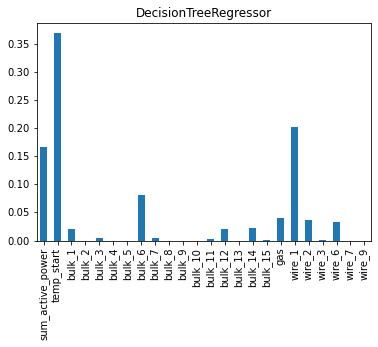

In [62]:
plot_bar(model)
plt.title('DecisionTreeRegressor')

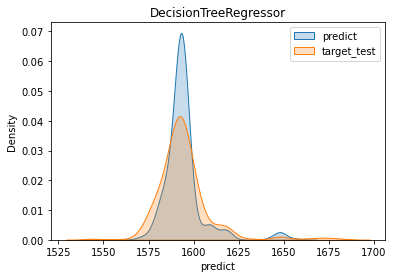

In [63]:
pred_tar(model, 'DecisionTreeRegressor')

## Проверка на тесте LassoCV

In [64]:
%%time

model = LassoCV()
model.set_params(**best_params_lasso)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_lasso = mean_absolute_error(target_predict, target_test)
print('MAE на тесте LassoCV =', test_mae_lasso)

MAE на тесте LassoCV = 7.908787229992551
Wall time: 266 ms


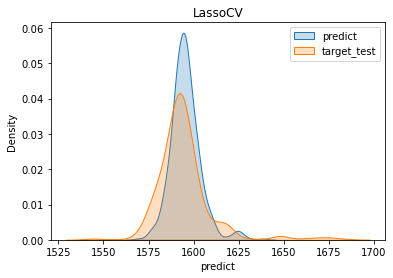

In [65]:
pred_tar(model, 'LassoCV')

In [66]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'DecisionTreeRegressor',
         'Lasso']
data = {'MAE на тесте':[test_mae_lr,
                        test_mae_rfr,
                        test_mae_cat,
                        test_mae_lgbm,
                        test_mae_dtr,
                        test_mae_lasso]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на тесте
LinearRegression,9.990581
RandomForestRegressor,6.284568
CatBoostRegressor,5.947278
LGBMRegressor,6.105618
DecisionTreeRegressor,7.413131
Lasso,7.908787


Итоговый вывод
В ходе работы над проектом было выполнено.

Подготовлены данные, удалены выбросы, а так же партии в кторых нет конечного замера температуры. определены и использованы номера партий, у которых есть замеры по температуре, пропуски заполнены нулями.
Подготовлены признаки. Составлена единая таблица со всеми данными для модели. Выделен целевой признак как последний замер температуры в серии замеров. Разделены на features и target.
Выбраны модели. Использованы и обучены регрессионные модели.
Оценена эффективность моделей на тестовой выборке.
Лучшей моделью по метрике MAE стал CatBoostRegressor. Другие модели RandomForestRegressor, LGBMRegressor, DecisionTreeRegressor и Lasso получили решение идеальной задачи. Так же выведены графики важности признаков моделей, кроме Lasso и LinearRegression, у этих моделей нет атрибутов для вывода важности признаков. так же были выведены графики с предсказаниями, для наглядности, что бы была понятно где и на сколько ошибается модель

# Финальный отчет

- После ознакомления с предоставлеными данными, был составлен план работы: выполнить предобработку данных, провести работу над пропусками либо удалить строки где отсутствовала важная информация, по типу отсутствия конечного замера температуры, выполнить объединение, и самое главное проверить на мультиколлинеарность. далее разделяем данные на features и target, обучаем разные модели, с подборкой гиперпарамметров, проверка на тестовой выборке, построение графиков, по предсказаниям и реальными данными, что бы было понятно где модель ощибается, а так же выводим анализ выажности признаков для каждой модели.  
- Основная трудность которую могу выделить, это не понимание что за данные, и что с ними делать, после консультации в зуме и консультации с тимлидом, и был составлен план работы  
- Основные шаги в решении задачи, это проверка на мультиколлинеарность, подбор гиперпараметров, в плоть до подбора значения random_state, и анализ важности факторов
- Самая лучшая итоговая модель получилось "CatBoostRegressor" с показателем МАЕ на тестовой выборке	5.947278
